In [ ]:
from google.colab import drive
import scipy.io
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# Mount Google Drive
drive.mount('/content/drive')

# Load data
x_train_path = "/content/drive/My Drive/x_train_Rician_CSCG_K10dB_60000_M8_N32_5dB (2).mat"
y_train_path = "/content/drive/My Drive/y_train_Rician_CSCG_K10dB_60000_M8_N32_5dB (1).mat"

x_train_data = scipy.io.loadmat(x_train_path)
y_train_data = scipy.io.loadmat(y_train_path)

A = x_train_data["x_train"]  # shape: (60000, 8, 33, 2)
H = y_train_data["y_train"]  # shape: (60000, 8, 33, 2)

# Convert to complex NumPy array
A_complex = A[..., 0] + 1j * A[..., 1]
H_complex = H[..., 0] + 1j * H[..., 1]

# Split into real and imaginary parts, convert to PyTorch tensors
A_real = torch.tensor(A_complex.real, dtype=torch.float32)
A_imag = torch.tensor(A_complex.imag, dtype=torch.float32)
H_real = torch.tensor(H_complex.real, dtype=torch.float32)
H_imag = torch.tensor(H_complex.imag, dtype=torch.float32)

# Concatenate real and imag parts along the last dimension
A_tensor = torch.cat([A_real, A_imag], dim=-1)  # shape: (60000, 8, 66)
H_tensor = torch.cat([H_real, H_imag], dim=-1)  # shape: (60000, 8, 66)

Mounted at /content/drive


In [ ]:
class ChannelDataset(Dataset):
    def __init__(self, A, H):
        self.A = A
        self.H = H

    def __len__(self):
        return len(self.A)

    def __getitem__(self, idx):
        return self.A[idx], self.H[idx]

batch_size = 64
dataset = ChannelDataset(A_tensor, H_tensor)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.attn = nn.MultiheadAttention(d_model, num_heads, batch_first=True)

    def forward(self, q, k, v):
        out, _ = self.attn(q, k, v)
        return out

class DistillationBlock(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

    def forward(self, x):
        x = x.transpose(1, 2)  # B x d_model x seq
        x = self.pool(x).transpose(1, 2)  # B x new_seq x d_model
        return x

class Encoder(nn.Module):
    def __init__(self, d_model, num_heads, num_layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Sequential(
                MultiHeadAttention(d_model, num_heads),
                nn.LayerNorm(d_model),
                DistillationBlock(d_model)
            )
            for _ in range(num_layers)
        ])

    def forward(self, x):
        for mha, norm, distill in self.layers:
            x = norm(mha(x, x, x) + x)
            x = distill(x)
        return x

class Decoder(nn.Module):
    def __init__(self, d_model, num_heads, num_layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.ModuleDict({
                'self_attn': MultiHeadAttention(d_model, num_heads),
                'cross_attn': MultiHeadAttention(d_model, num_heads),
                'norm1': nn.LayerNorm(d_model),
                'norm2': nn.LayerNorm(d_model),
            })
            for _ in range(num_layers)
        ])
        self.output_layer = nn.Linear(d_model, d_model)

    def forward(self, x, enc_out):
        for layer in self.layers:
            x = layer['norm1'](layer['self_attn'](x, x, x) + x)
            x = layer['norm2'](layer['cross_attn'](x, enc_out, enc_out) + x)
        return self.output_layer(x)

class EPformer(nn.Module):
    def __init__(self, input_dim, d_model=64, num_heads=4, num_layers=2):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.encoder = Encoder(d_model, num_heads, num_layers)
        self.decoder = Decoder(d_model, num_heads, num_layers)
        self.output_proj = nn.Linear(d_model, input_dim)

    def forward(self, x):
        x = self.input_proj(x)
        enc_out = self.encoder(x)
        dec_input = F.avg_pool1d(x.transpose(1, 2), kernel_size=2, stride=2).transpose(1, 2)
        dec_out = self.decoder(dec_input, enc_out)
        return self.output_proj(dec_out)


Epoch 1/30, Loss: 0.524470
Epoch 2/30, Loss: 0.256622
Epoch 3/30, Loss: 0.230084
Epoch 4/30, Loss: 0.225684
Epoch 5/30, Loss: 0.211542
Epoch 6/30, Loss: 0.209164
Epoch 7/30, Loss: 0.207916
Epoch 8/30, Loss: 0.207000
Epoch 9/30, Loss: 0.206247
Epoch 10/30, Loss: 0.205613
Epoch 11/30, Loss: 0.205152
Epoch 12/30, Loss: 0.204713
Epoch 13/30, Loss: 0.204238
Epoch 14/30, Loss: 0.203891
Epoch 15/30, Loss: 0.203614
Epoch 16/30, Loss: 0.203286
Epoch 17/30, Loss: 0.203033
Epoch 18/30, Loss: 0.202755
Epoch 19/30, Loss: 0.202564
Epoch 20/30, Loss: 0.202304
Epoch 21/30, Loss: 0.202175
Epoch 22/30, Loss: 0.202018
Epoch 23/30, Loss: 0.201794
Epoch 24/30, Loss: 0.201626
Epoch 25/30, Loss: 0.201504
Epoch 26/30, Loss: 0.201358
Epoch 27/30, Loss: 0.201287
Epoch 28/30, Loss: 0.201151
Epoch 29/30, Loss: 0.201019
Epoch 30/30, Loss: 0.200928


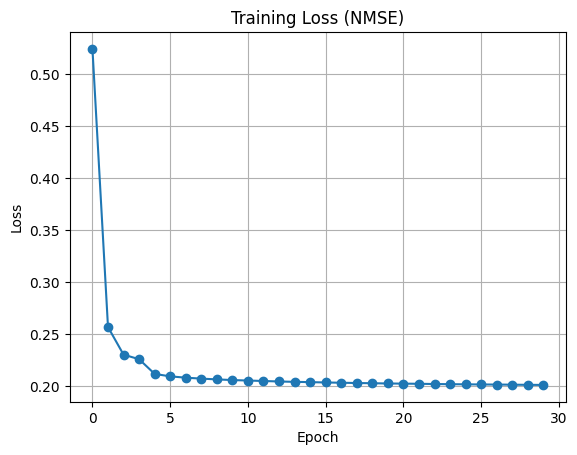

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EPformer(input_dim=66).to(device)

def nmse_loss(pred, target):
    return torch.mean(torch.norm(pred - target, dim=-1)**2 / torch.norm(target, dim=-1)**2)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training
import matplotlib.pyplot as plt

num_epochs = 30
epoch_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for A_batch, H_batch in train_loader:
        A_batch, H_batch = A_batch.to(device), H_batch.to(device)
        optimizer.zero_grad()
        H_pred = model(A_batch)

        # Match decoder output shape
        if H_pred.shape[1] != H_batch.shape[1]:
            H_batch = H_batch[:, :H_pred.shape[1], :]

        loss = nmse_loss(H_pred, H_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}")

# Plot loss curve
plt.plot(epoch_losses, marker='o')
plt.title("Training Loss (NMSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [ ]:
def compute_mmse_estimate(A_tensor, H_tensor):
    A_flat = A_tensor.reshape(-1, A_tensor.shape[-1])  # (N*L, 66)
    H_flat = H_tensor.reshape(-1, H_tensor.shape[-1])

    A_mean = A_flat.mean(dim=0, keepdim=True)
    H_mean = H_flat.mean(dim=0, keepdim=True)

    A_centered = A_flat - A_mean
    H_centered = H_flat - H_mean

    R_AA = A_centered.T @ A_centered / A_centered.shape[0]
    R_HA = H_centered.T @ A_centered / A_centered.shape[0]

    R_AA_inv = torch.linalg.pinv(R_AA)
    W_mmse = R_HA @ R_AA_inv

    H_est = (W_mmse @ (A_flat - A_mean).T).T + H_mean
    return H_est.reshape(H_tensor.shape)

with torch.no_grad():
    H_mmse_pred = compute_mmse_estimate(A_tensor, H_tensor)
    mmse_loss = nmse_loss(H_mmse_pred.to(device), H_tensor.to(device))
    print(f"MMSE NMSE Loss: {mmse_loss.item():.6f}")


MMSE NMSE Loss: 0.244454
